In [1]:
import sys
sys.path.append('../src')
from data import get_cleaned_dataframes, get_cleaned_dataframe_with_topics
from models import classification, get_embedding_model, get_BERTopic_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


loaded spacy language model: de_core_news_sm


load the preprocessed texts in all languages into a dataframe

In [2]:
cleaned_dataframe = get_cleaned_dataframes()

In [3]:
bertopic_model = get_BERTopic_model('sentences')
topics_dataframe = get_cleaned_dataframe_with_topics(bertopic_model)

Split data into train and test sets

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(topics_dataframe['cleaned_texts'], topics_dataframe['label'] , test_size=0.3)

## Word2Vec & fastText
### Parameters:
- vector_size - vector size
- window - num of words before and after the focus word considered as context for the word
- min_count - the number of times a word must appear in our corpus in order to create a word vector.

Train a Word2Vec model with the train set

In [7]:
model, word_vectors = get_embedding_model(X_train, method = "fastText", text_type="cleaned_texts_topics")

Word2Vec model not found.
Training new model on 181 documents.
Saving new model.
Model:  /home/Bachelor-Thesis/models/classification/FastText/FastText_de_cleaned_texts_topics  loaded


In [9]:
print(word_vectors)

FastTextKeyedVectors<vector_size=100, 4687 keys>


## Text Classification on manually trained Embedding model

### Create features from text for machine learning model.
Steps:
- Turn words in texts into word vectors.
- Method 1: averaging word vectors for each text

In [10]:
X_train_vect = classification.text2vec(X_train, word_vectors)
X_test_vect = classification.text2vec(X_test, word_vectors)

In [11]:
X_train_vect_avg = classification.average_vector(X_train_vect)
X_test_vect_avg = classification.average_vector(X_test_vect)

### Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correctly classified among that class
- f1-score: harmonic mean between precision and recall
- support: num of occurrence of given class in dataset

Instantiate and fit a basic Random Forest model on top of the vectors

In [12]:
y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "SVM")
classification.print_classification_report(y_test, y_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.97      0.85      0.91        74
    begnadet       0.15      0.50      0.24         4

    accuracy                           0.83        78
   macro avg       0.56      0.68      0.57        78
weighted avg       0.93      0.83      0.87        78

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.52      0.85      0.65        40
    begnadet       0.54      0.18      0.27        38

    accuracy                           0.53        78
   macro avg       0.53      0.52      0.46        78
weighted avg       0.53   

<AxesSubplot: ylabel='label'>

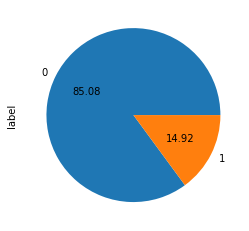

In [13]:
y_train.value_counts().plot.pie(autopct='%0.2f')

Highly Imbalanced Dataset!
Ideas:
- Undersampling: reduce majority class to make it equal to minority class
- Oversampling: increase minority class to make it equal to majority class through resampling
- K-fold cross validation

## Oversampling

In [14]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
X_res, y_res = ros.fit_resample(X_train_2d, y_train)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


0    154
1    154
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

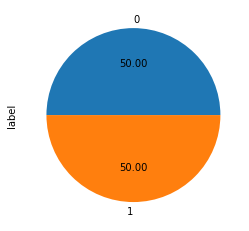

In [15]:
print(y_res.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [16]:
#X_res revert 2_dimensionality
X_res_1d = X_res.flatten()

# classification with resampled vectors
X_res_vect = classification.text2vec(X_res_1d, word_vectors)
X_res_vect_avg = classification.average_vector(X_res_vect)

In [17]:
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "SVM")
classification.print_classification_report(y_test, y_res_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.78      0.86      0.82        59
    begnadet       0.38      0.26      0.31        19

    accuracy                           0.72        78
   macro avg       0.58      0.56      0.57        78
weighted avg       0.69      0.72      0.70        78

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.18      0.80      0.30        15
    begnadet       0.77      0.16      0.26        63

    accuracy                           0.28        78
   macro avg       0.48      0.48      0.28        78
weighted avg       0.66   

## Undersampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")
X_resampled, y_resampled = rus.fit_resample(X_train_2d, y_train)

0    27
1    27
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

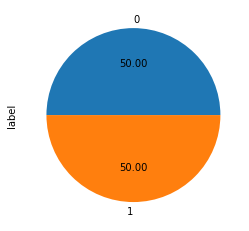

In [19]:
print(y_resampled.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [20]:
#X_res revert 2_dimensionality
X_resampled_1d = X_resampled.flatten()

# classification with resampled vectors
X_resampled_vect = classification.text2vec(X_resampled_1d, word_vectors)
X_resampled_vect_avg = classification.average_vector(X_resampled_vect)

In [21]:
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Random Forest")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "SVM")
classification.print_classification_report(y_test, y_resampled_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.38      0.83      0.53        30
    begnadet       0.62      0.17      0.26        48

    accuracy                           0.42        78
   macro avg       0.50      0.50      0.39        78
weighted avg       0.53      0.42      0.36        78

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.18      0.75      0.30        16
    begnadet       0.69      0.15      0.24        62

    accuracy                           0.27        78
   macro avg       0.44      0.45      0.27        78
weighted avg       0.59   